In [11]:
import csv
import numpy as np
import pandas as pd
from collections import defaultdict
import string
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics # confusion matrix, MSE etc.
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/t.z.cheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
path_to_data = '/Users/t.z.cheng/Google_Drive/Coursework/CSE258/assignment/assignment2/profiles.csv'

In [7]:
def read_data(path):
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        for d in reader:
            d["full_essay"] = " \n ".join([d[f'essay{i}'] for i in range(10)]) ## join the essays together
            yield d      

In [8]:
## Read the data
df = pd.read_csv(path_to_data)
data = list(read_data(path_to_data))
train = data[:30000]
valid = data[30000:40000]
test = data[40000:]

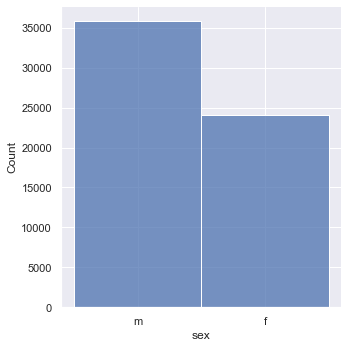

In [12]:
## Gender
df['sex'].value_counts()
sns.set(rc={'figure.figsize':(10,5)})
sns.displot(x='sex', data=df)

In [13]:
df['sex_cleaned'] = [1 if d == 'f' else 0 for d in df['sex']]
df['sex_cleaned'].value_counts()

0    35829
1    24117
Name: sex_cleaned, dtype: int64

In [16]:
bigram_count = defaultdict(int)
unigram_count = defaultdict(int)

punct = string.punctuation
stemmer = PorterStemmer()
for d in train:
    text = d["full_essay"]
    text = text.lower()
    text = [c for c in text if not (c in punct)]
    text = "".join(text)
    text = text.strip().split()
    text = [stemmer.stem(w) for w in text]
    
    for i in range(len(text) -1 ):
        bigram_count[(text[i], text[i+1])] += 1
    for i in range(len(text)):
        unigram_count[text[i]] += 1
    
for sw in stopwords.words("english"):
    try:
        del unigram_count[sw]
    except KeyError:
        continue

    for a,b in list(bigram_count.keys()):
        if a == sw or b == sw:
            try:
                del bigram_count[(a,b)]
            except KeyError:
                pass
        
print("done")
print(len(bigram_count), len(unigram_count))

done
1465167 208005


In [18]:
sorted_bigram_count = sorted(bigram_count.items(), key = lambda x:-x[1])
top_bigram = sorted_bigram_count[:1000]
top_bigram_words = [w for w,_ in top_bigram]

sorted_unigram_count = sorted(unigram_count.items(), key = lambda x:-x[1])
top_unigram = sorted_unigram_count[:1000]
top_unigram_words = [w for w,_ in top_unigram]

unigram_id = dict(zip(top_unigram_words, range(len(top_unigram_words))))
bigram_id = dict(zip(top_bigram_words, range(len(top_bigram_words))))

### Use the frequency of unigram and bigram to predict gender

In [37]:
def feature(d): 
    text = d["full_essay"]
    text = text.lower()
    text = [c for c in text if not (c in punct)]
    text = "".join(text)
    text = text.strip().split()
    text = [stemmer.stem(w.strip()) for w in text]
        
    feat = [0]*( len(unigram_id)+len(bigram_id) )
    
    for w in text:
        tf[w] += 1
    for w in tf:
        if w not in unigram_id: continue
        feat[unigram_id[w]] = tf[w] * idf[w]
    
    for i in range(len(text)-1):
        if not ((text[i], text[i+1]) in bigram_id): continue
        feat[len(unigram_id) + bigram_id[(text[i], text[i+1])]] += 1
        
    feat.append(1)
    return feat

### Use the tfidf to predict gender

In [ ]:
## idf unigram
idf = defaultdict(float)
total_doc = len(train)
for w,c in unigram_count.items():
    idf[w] = -np.log(c/total_doc)

In [19]:
## unigram tfidf
def feature(d):
    feat = [0]*len(unigram_id) 
    tf = defaultdict(int)
    
    for w in d["full_essay"]:
        tf[w] += 1
        
    for w in tf:
        if w not in unigram_id: continue
        feat[unigram_id[w]] = tf[w] * idf[w]
        
    # feat.append(1) # Don't need this, model adds by default
    return feat

### Modeling

In [38]:
xtrain = [feature(d) for d in train]
ytrain = ["f" in d['sex'] for d in train]

xvalid = [feature(d) for d in valid]
yvalid = ["f" in d['sex'] for d in valid]

xtest = [feature(d) for d in test]
ytest = ["f" in d['sex'] for d in test]

In [52]:
clf = linear_model.LogisticRegression(C=1, solver='lbfgs',  max_iter=10000)
clf.fit(xtrain, ytrain)
theta = clf.coef_
predictions = clf.predict(xvalid)

In [40]:
## Trivial predictor: predict all are males
df['sex_cleaned'].value_counts()[0]/(df['sex_cleaned'].value_counts()[0]+df['sex_cleaned'].value_counts()[1])

0.5976879191272145

In [53]:
print("accuracy: ",metrics.accuracy_score(predictions, yvalid))

accuracy:  0.7559


In [54]:
## BER
TP_ = np.logical_and(np.array(yvalid) == True, predictions == True)
FP_ = np.logical_and(np.array(yvalid) == False, predictions == True)
TN_ = np.logical_and(np.array(yvalid) == False, predictions == False)
FN_ = np.logical_and(np.array(yvalid) == True, predictions == False)
TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)
BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
print('BER:',BER)

BER: 0.2703273822106529


### Find the top unigram and bigram

In [22]:
top_unigram_words[:5]

['br', 'im', 'like', 'love', 'classilink']

In [23]:
weights = list(zip(theta[0], top_unigram_words))
weights.sort()
print(weights[:5])
print(weights[-5:])

[(-0.04527141814634612, '2'), (-0.019522917441990736, '7'), (-0.018814355705352098, '4'), (-0.01591569868589094, '6'), (-0.011106855817984642, '1')]
[(0.0, 'youll'), (0.0, 'young'), (0.0, 'youv'), (0.0010530520729103952, 'n'), (0.01691633538408152, '5')]


In [41]:
print("accuracy: ",metrics.accuracy_score(predictions, yvalid))

accuracy:  0.744


In [25]:
## idf bigram
idf = defaultdict(float)
total_doc = len(train)
for w,c in bigram_count.items():
    idf[w] = -np.log(c/total_doc)

In [26]:
## bigram tfidf
def feature(d):
    feat = [0]*len(bigram_id) 
    tf = defaultdict(int)
    
    for w in d["full_essay"]:
        tf[w] += 1
        
    for w in tf:
        if w not in bigram_id: continue
        feat[bigram_id[w]] = tf[w] * idf[w]
        
    # feat.append(1) # Don't need this, model adds by default
    return feat

In [27]:
xtrain = [feature(d) for d in train]
ytrain = ["f" in d['sex'] for d in train]

xvalid = [feature(d) for d in valid]
yvalid = ["f" in d['sex'] for d in valid]

xtest = [feature(d) for d in test]
ytest = ["f" in d['sex'] for d in test]

In [28]:
clf = linear_model.LogisticRegression(C=1, solver='lbfgs', class_weight = 'balanced', max_iter=10000)
clf.fit(xtrain, ytrain)
theta = clf.coef_
predictions = clf.predict(xvalid)

In [29]:
print("accuracy: ",metrics.accuracy_score(predictions, yvalid))

accuracy:  0.6076


In [62]:
## BER
TP_ = np.logical_and(np.array(yvalid) == True, predictions == True)
FP_ = np.logical_and(np.array(yvalid) == False, predictions == True)
TN_ = np.logical_and(np.array(yvalid) == False, predictions == False)
FN_ = np.logical_and(np.array(yvalid) == True, predictions == False)
TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)
BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
print('BER:',BER)

BER: 0.5


In [63]:
weights = list(zip(theta[0], top_bigram_words))
weights.sort()
print(weights[:5])
print(weights[-5:])

[(-0.6924125602067639, ('ive', 'got')), (-0.6418697486837696, ('five', 'year')), (-0.5920851675711589, ('also', 'pretti')), (-0.4857602091676884, ('comput', 'scienc')), (-0.4650101847657169, ('come', 'back'))]
[(0.4658416765237147, ('get', 'lost')), (0.49293218049277154, ('good', 'peopl')), (0.5591073152158113, ('good', 'book')), (0.607577496188865, ('also', 'spend')), (0.6203419225004301, ('br', 'current'))]


0.5976879191272145

In [ ]:
# Drop rows without spoken language
df = df.dropna(axis=0, subset=['speaks'])

In [ ]:
# Define target variable as 1 if speaks c++ or lisp, 0 otherwise
df['target'] = [1 if ("c++" in df['speaks'].iloc[i] or "lisp" in df['speaks'].iloc[i]) else 0 for i in range(len(df))]

In [ ]:
# Determine % of target 
sum(df['target']) / len(df)

In [ ]:
len(df)

In [ ]:
df.head(50)

In [58]:
predictions[-10:]

[False, False, False, False, False, False, False, False, False, False]

In [56]:
predictions = [False for i in np.arange(0,len(predictions))]

In [61]:
predictions = np.array(predictions)